## Seq2Seq : Sequence to Sequence 모델
#### : Encoder Decoder  모델이라고도 한다


In [1]:
from nn_layers import TimeEmbedding, TimeAffine, TimeLSTM, TimeSoftmaxWithLoss
import numpy as np
import pickle

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [16]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H =  vocab_size, wordvec_size, hidden_size # 10000, 100, 100
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')
        
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f') # Xavier(GLorot) 초기화
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        # 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        # 가중치 기울기 모으기
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)    # (N,T,H)
        self.hs = hs
        return hs[:,-1,:]  # TimeLSTM 계층의 마지막 은닉 상태 h를 반환, [N,H], 2차원
    
    def backward(self,dh):
        dhs = np.zeros_like(self.hs) # (N,T,H)
        dhs[:,-1,:] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout  
        

In [22]:
class Decoder:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params,self.grads = [],[]
        for layer in (self.embed,self.lstm,self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
            
    def forward(self,xs,h):           # h : Encoder의 출력, (N,H)
        self.lstm.set_state(h)     
        out = self.embed.forward(xs)
        out = self.lstm.forward(out) 
        score = self.affine.forward(out)
        return score     # softmax를 통과시키지 않고 그냥 출력
    
    def backward(self,dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        
        dh = self.lstm.dh     # TimeLSTM의 backward()에서 dh가 얻어져 저장 되어 있으므로
        
        return dh             # Encoder 에 전달 
    
    # 문장 생성시 호출
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())  # 가장 큰값 index
            sampled.append(int(sample_id))
        return sampled

In [18]:
class Seq2seq:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self,xs,ts):
        decoder_xs, decoder_ts = ts[:,:-1], ts[:,1:] # decoder의 입력: 마지막 단어를 제외
                                                     # softmaxwithloss 의 입력 : 첫 단어를 제외
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs,h)
        loss = self.softmax.forward(score,decoder_ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self,xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h,start_id,sample_size)
        
        return sampled

## 학습 데이터 준비
### Toy Data Set : 'addition.txt'

- 글자 하나가 word (띄어쓰기, _포함)
- 13개 vocabulary

In [19]:
from dataset import sequence

# 'addition.txt': 총 50000개 덧셈 연산 예를 가짐

# 덧셈식을 일반 문장과 같이 corpus를 생성하고 seed가 고정된 랜덤으로 뒤섞고 90:10 비율로 학습과 검증 데이터를 분리해준다
# x는 덧셈식, t는 덧셈 결과값

(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)

char_to_id ,id_to_char = sequence.get_vocab()

print(char_to_id)
print(id_to_char)
# 총 13개의 문자를 value로 갖음: '0','1','2','3','4','5','6','7','8','9','+',' ','_'

print(x_train.shape,t_train.shape)  # (45000, 7) (45000, 5)
print(x_test.shape,t_test.shape)    # (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])

print(''.join(id_to_char[c] for c in x_train[0])) # 71+118 
print(''.join(id_to_char[c] for c in t_train[0])) # _189

print(''.join(id_to_char[c] for c in x_train[1]))   
print(''.join(id_to_char[c] for c in t_train[1])) 


{'1': 0, '6': 1, '+': 2, '7': 3, '5': 4, ' ': 5, '_': 6, '9': 7, '2': 8, '0': 9, '3': 10, '8': 11, '4': 12}
{0: '1', 1: '6', 2: '+', 3: '7', 4: '5', 5: ' ', 6: '_', 7: '9', 8: '2', 9: '0', 10: '3', 11: '8', 12: '4'}
(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 
510+223
_733 


In [20]:
import os

def eval_seq2seq(model, question, correct, id_to_char,
                 verbose=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbose:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}  # https://norux.me/29 , 이스케이프 문자
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'
    
        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0

### 학습

In [24]:
from nn_layers import Adam,Trainer,TimeEmbedding,TimeLSTM,TimeAffine,TimeSoftmaxWithLoss
import matplotlib.pyplot as plt
from dataset import sequence
import numpy as np

(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)
char_to_id ,id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정
is_reverse = False

# 하이퍼 파라미터 설정
vocab_size = len(char_to_id)  # 13개
wordvec_size = 16
hidden_size = 128
batch_size = 128

max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size,wordvec_size,hidden_size)

optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []


for epoch in range(max_epoch): # 25회
    trainer.fit(x_train,t_train,max_epoch=1,
                batch_size=batch_size,max_grad=max_grad)
    
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10  # 최초 10개만 맞았는지 틀렸는지  출력
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
# 약 6~7분 소요 
# 검증 정확도  8.620% ==> 정확도가 낮다


## Seq2seq 개선
### 1. 입력 데이터의 순서를 반전 시키면 학습 진행이 빨라져서 최종 정확도가 향상된다


In [25]:
(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)
char_to_id ,id_to_char = sequence.get_vocab()

print('원본:',x_train[0],x_test[0])

# 입력 반전 여부 설정
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:,::-1],x_test[:,::-1] # 열의 순서를 거꾸로 변경
    
print('반전:',x_train[0],x_test[0])
# 하이퍼 파라미터 설정
vocab_size = len(char_to_id)  # 13개
wordvec_size = 16
hidden_size = 128
batch_size = 128

max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size,wordvec_size,hidden_size)

optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []

for epoch in range(max_epoch): # 25회
    trainer.fit(x_train,t_train,max_epoch=1,
                batch_size=batch_size,max_grad=max_grad)
    
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10  # 최초 10개만 맞았는지 틀렸는지  출력
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    
# 약 6~7분 소요 
# 검증 정확도향상  8.620% ==> 54.280%

원본: [ 3  0  2  0  0 11  5] [ 3  3  2 11  4  5  5]
반전: [ 5 11  0  0  2  0  3] [ 5  5  4 11  2  3  3]
| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 14[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 17[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 

| 에폭 8 |  반복 281 / 351 | 시간 15[s] | 손실 0.59
| 에폭 8 |  반복 301 / 351 | 시간 16[s] | 손실 0.58
| 에폭 8 |  반복 321 / 351 | 시간 17[s] | 손실 0.57
| 에폭 8 |  반복 341 / 351 | 시간 18[s] | 손실 0.57
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1134
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 423 
---
Q 600+257
T 857 
X 759 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1431
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 5[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 6[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 7[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 8[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 9[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 10[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 11[s] | 손실 0.54
| 에폭 9 |  반복 241 

| 에폭 16 |  반복 61 / 351 | 시간 3[s] | 손실 0.36
| 에폭 16 |  반복 81 / 351 | 시간 4[s] | 손실 0.37
| 에폭 16 |  반복 101 / 351 | 시간 5[s] | 손실 0.36
| 에폭 16 |  반복 121 / 351 | 시간 6[s] | 손실 0.37
| 에폭 16 |  반복 141 / 351 | 시간 7[s] | 손실 0.36
| 에폭 16 |  반복 161 / 351 | 시간 8[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 9[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 10[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 11[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 12[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 13[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 14[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 15[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 16[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 18[s] | 손실 0.37
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1430
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.

| 에폭 23 |  반복 321 / 351 | 시간 20[s] | 손실 0.29
| 에폭 23 |  반복 341 / 351 | 시간 21[s] | 손실 0.28
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 238 
---
검증 정확도 45.160%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 6[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 8[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 10[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 11[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 12[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 14[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 15[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 16[s] | 손실 0.29

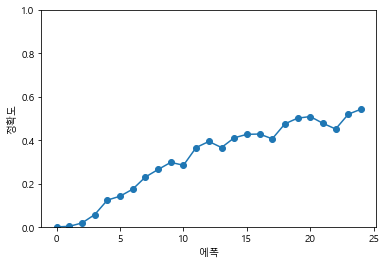

In [26]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### 2. PeekySeq2seq

In [27]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # D --> H + D , concat으로 인하여 H만큼 추가됨
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')    # H --> H + H , concat으로 인하여 H만큼 추가됨
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # 입력된 h를 시계열 갯수 만큼 복제한다
        out = np.concatenate((hs, out), axis=2)       # Embedding 계층 출력과 hs를 concatenate한다

        out = self.lstm.forward(out)                  # LSTM 계층의 forward에 합쳐진 out을 전달
        out = np.concatenate((hs, out), axis=2)       # LSTM 계층 출력과 hs를 concatenate한다

        score = self.affine.forward(out)              # Affine계층의 forward에 합쳐진 out을 전달
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1        # Affine의 backward 출력 dhs0과 LSTM의 backward 출력 dhs1을 더한다
        dh = self.lstm.dh + np.sum(dhs, axis=1) # LSTM의 backward출력 dh와 dhs의 수평합과 더한다, 최종 출력값
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)  # 입력된 peeky_h를 Embedding 계층 출력과 concatenate한다
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)  # 입력된 peeky_h를 LSTM 계층 출력과 concatenate한다
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())          # 점수가 가장 큰 문자의 ID를 선택
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq): # Seq2seq클래스를 상속하여 구현, forward(),backward(),generate() 메서드는 모두 동일
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)  # PeekyDecoder사용, 이 부분만 Seq2seq클래스와 다르다
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [28]:
(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt', seed = 1984)
char_to_id ,id_to_char = sequence.get_vocab()

print('원본:',x_train[0],x_test[0])

# 입력 반전 여부 설정
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:,::-1],x_test[:,::-1] # 열의 순서를 거꾸로 변경
    
print('반전:',x_train[0],x_test[0])
# 하이퍼 파라미터 설정
vocab_size = len(char_to_id)  # 13개
wordvec_size = 16
hidden_size = 128
batch_size = 128

max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size,wordvec_size,hidden_size)

optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []

for epoch in range(max_epoch): # 25회
    trainer.fit(x_train,t_train,max_epoch=1,
                batch_size=batch_size,max_grad=max_grad)
    
    correct_num = 0
    
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10  # 최초 10개만 맞았는지 틀렸는지  출력
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

원본: [ 3  0  2  0  0 11  5] [ 3  3  2 11  4  5  5]
반전: [ 5 11  0  0  2  0  3] [ 5  5  4 11  2  3  3]
| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 17[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 18[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 

| 에폭 8 |  반복 281 / 351 | 시간 17[s] | 손실 0.36
| 에폭 8 |  반복 301 / 351 | 시간 18[s] | 손실 0.36
| 에폭 8 |  반복 321 / 351 | 시간 19[s] | 손실 0.35
| 에폭 8 |  반복 341 / 351 | 시간 20[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 5[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 7[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 8[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 9[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 10[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 11[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 12[s] | 손실 0.25
| 에폭 9 |  반복 241

| 에폭 16 |  반복 61 / 351 | 시간 3[s] | 손실 0.04
| 에폭 16 |  반복 81 / 351 | 시간 4[s] | 손실 0.04
| 에폭 16 |  반복 101 / 351 | 시간 5[s] | 손실 0.04
| 에폭 16 |  반복 121 / 351 | 시간 7[s] | 손실 0.05
| 에폭 16 |  반복 141 / 351 | 시간 8[s] | 손실 0.05
| 에폭 16 |  반복 161 / 351 | 시간 9[s] | 손실 0.04
| 에폭 16 |  반복 181 / 351 | 시간 11[s] | 손실 0.05
| 에폭 16 |  반복 201 / 351 | 시간 12[s] | 손실 0.04
| 에폭 16 |  반복 221 / 351 | 시간 13[s] | 손실 0.04
| 에폭 16 |  반복 241 / 351 | 시간 14[s] | 손실 0.04
| 에폭 16 |  반복 261 / 351 | 시간 16[s] | 손실 0.04
| 에폭 16 |  반복 281 / 351 | 시간 17[s] | 손실 0.04
| 에폭 16 |  반복 301 / 351 | 시간 18[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 19[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 21[s] | 손실 0.03
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 97.220%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0

| 에폭 23 |  반복 321 / 351 | 시간 19[s] | 손실 0.01
| 에폭 23 |  반복 341 / 351 | 시간 20[s] | 손실 0.01
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 98.720%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.01
| 에폭 24 |  반복 101 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 141 / 351 | 시간 8[s] | 손실 0.01
| 에폭 24 |  반복 161 / 351 | 시간 9[s] | 손실 0.01
| 에폭 24 |  반복 181 / 351 | 시간 10[s] | 손실 0.01
| 에폭 24 |  반복 201 / 351 | 시간 11[s] | 손실 0.01
| 에폭 24 |  반복 221 / 351 | 시간 12[s] | 손실 0.01
| 에폭 24 |  반복 241 / 351 | 시간 14[s] | 손실 0.01
| 에폭 24 |  반복 261 / 351 | 시간 15[s] | 손실 0.01


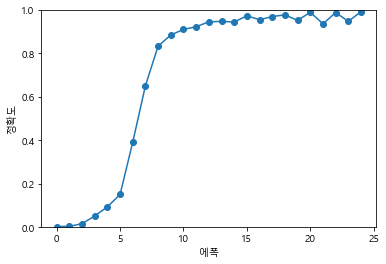

In [31]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

## attention

#### 맥락 벡터 : 단어 벡터에 가중치를 곱하여 합한 가중합을 구한 벡터
- 단어를 선택하는 작업은 미분 불가하므로 모든 것을 선택하고 단어의 중요도를 가중치로 계산

In [30]:
np.random.seed(100)
T,H = 5,4
hs = np.random.randn(T,H)
print('hs : \n',hs)

a  = np.array([0.8, 0.1, 0.03, 0.05, 0.02]) # 가중치

# (1) repeat 사용

ar = a.reshape(T,1).repeat(H,axis=1)
print('ar : \n',ar, ar.shape)

t = hs * ar
print('t : \n',t, t.shape)

hs : 
 [[-1.74976547  0.3426804   1.1530358  -0.25243604]
 [ 0.98132079  0.51421884  0.22117967 -1.07004333]
 [-0.18949583  0.25500144 -0.45802699  0.43516349]
 [-0.58359505  0.81684707  0.67272081 -0.10441114]
 [-0.53128038  1.02973269 -0.43813562 -1.11831825]]
ar : 
 [[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]] (5, 4)
t : 
 [[-1.39981238  0.27414432  0.92242864 -0.20194883]
 [ 0.09813208  0.05142188  0.02211797 -0.10700433]
 [-0.00568487  0.00765004 -0.01374081  0.0130549 ]
 [-0.02917975  0.04084235  0.03363604 -0.00522056]
 [-0.01062561  0.02059465 -0.00876271 -0.02236636]] (5, 4)


In [34]:
# (2) broadcasting

ar = a.reshape(T,1)
print('ar : \n',ar, ar.shape)

t = hs * ar
print('t : \n',t, t.shape)

c = np.sum(t, axis= 0 ) # 가중합(맥락 벡터)
print('c : ',c)
print('hs[0] : ',hs[0])

ar : 
 [[0.8 ]
 [0.1 ]
 [0.03]
 [0.05]
 [0.02]] (5, 1)
t : 
 [[-1.39981238  0.27414432  0.92242864 -0.20194883]
 [ 0.09813208  0.05142188  0.02211797 -0.10700433]
 [-0.00568487  0.00765004 -0.01374081  0.0130549 ]
 [-0.02917975  0.04084235  0.03363604 -0.00522056]
 [-0.01062561  0.02059465 -0.00876271 -0.02236636]] (5, 4)
c :  [-1.34717053  0.39465326  0.95567913 -0.32348518]
hs[0] :  [-1.74976547  0.3426804   1.1530358  -0.25243604]


In [36]:
N, T, H = 10, 5, 4      # 면,행,열
hs = np.random.randn(N, T, H)
# print('hs:\n',hs)

np.random.seed(100)
a  = np.random.randn(N, T)  # 가중치의 합이 1이 아닌 예임
# print('a:\n',a)

ar = a.reshape(N, T, 1).repeat(H, axis=2)  # 2번축(열)로 4번 반복
# print('ar:\n',ar)

t = hs * ar  # (10,5, 4)
# print('t:\n',t)
print(t.shape)

c = np.sum(t, axis=1)  # 1번 축(행)으로 합 
print('c:\n',c)
print(c.shape)

(10, 5, 4)
c:
 [[ 2.56581018  0.82908439  1.7532527   0.75650542]
 [-0.79335524  1.08405632 -1.03826593 -1.76550127]
 [-0.65312003  1.32587424  0.11241816 -0.03641957]
 [-2.13599389  1.02892947 -3.28073992  1.63955976]
 [-5.26003954 -1.77363646 -1.58133902  2.09433462]
 [ 3.17092101 -0.72839889  0.92403074 -0.54670656]
 [ 0.3798197  -3.55664112  1.24670311  0.17375865]
 [-2.85094054  0.6052316  -2.25692566  0.43953489]
 [-1.60256472  0.42583908  0.88191215  0.5054533 ]
 [ 3.04316414 -0.55811351  0.25334528 -0.90971243]]
(10, 4)


In [ ]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self,):
        
        
    def backward(self,)